# HW 3. Сканнер судоку

В этом задании, вам предлагается решить задачу распознавания чисел на решетке судоку. Для этого вам нужно реализовать следующие функции:

1. Конвертация в нужное цветовое пространство
2. Поиск решетки на изображении через контуры
3. Перспектива решетки судоку для распознавания
4. Выделение ячеек с числами
5. Обучение нейронной сети на MNIST
6. Распознавание цифр в судоку с помощью сети

## Старт

In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
def READ_RGB(path):
    image=cv2.imread(path)
    return cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

def SHOW_IMAGE(image):
    plt.imshow(image,cmap='gray')
    plt.show()

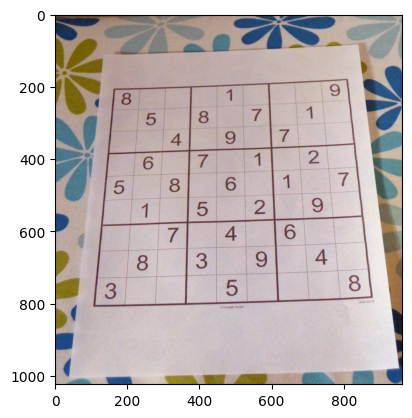

In [3]:
# Загружаем изображение
img_rgb = READ_RGB("sudoku.jpg")
SHOW_IMAGE(img_rgb)

## Бинаризация

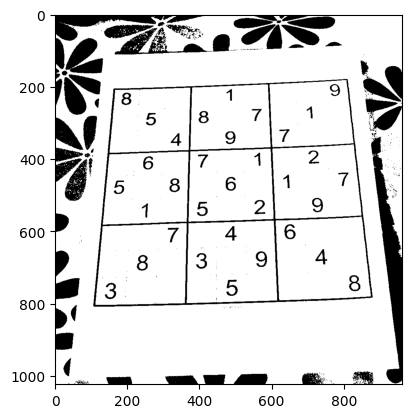

In [4]:
# Перевод из RBG в Grayscale и накладываем фильтр
# Write your code here
img_gray = img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
img_filtered = cv2.GaussianBlur(img_gray, (7,7), 0.1)
# Бинаризация
# Write your code here
img_bin =  cv2.threshold(img_filtered, 128, 255, cv2.THRESH_BINARY)[1]

SHOW_IMAGE(img_bin)

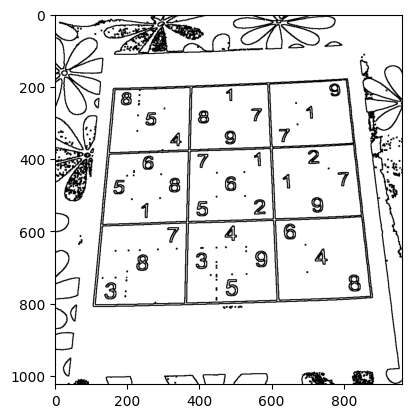

In [5]:
# canny и увеличение толщины контуров (не используется далее, только вывод картинки как в задании)
canny_img = cv2.Canny(img_bin,100,200)

kernel = np.ones((3, 3), np.uint8)  # Увеличение толщины контуров (больше сетка толще контур)
canny_img = cv2.dilate(canny_img, kernel, iterations=1)

canny_img=canny_img-255

SHOW_IMAGE(canny_img)

## Поиск контуров

На этом этапе мы хотим найти решетку с судоку. По нашему предположению, это наибольший по площади четырехугольник

In [6]:
# Функция для уменьшения ребер в контуре, как на предыдущей лабе
def Approximating(contour,epsilon=.1):
    # Периметр контура
    length=cv2.arcLength(contour,True)
    # Аппроксимирует контурную форму к форме с меньшим количеством вершин 
    # в зависимости от указанной точности. Это реализация алгоритма Рамера — Дугласа — Пекера.
    approx=cv2.approxPolyDP(contour,epsilon*length,True)
    return approx

In [7]:
# Найдите контуры с помощью opencv
# Write your code here
contours, hierarchy = cv2.findContours(
    img_bin,                    # бинаризованное изображение
    cv2.RETR_TREE ,             # режим извлечения контуров (RETR_EXTERNAL — только внешние)
    cv2.CHAIN_APPROX_SIMPLE     # метод аппроксимации (упрощает контур, экономя память)
)

In [8]:
img_contours = img_rgb.copy()
# Write your code here
# Отсортируйте контуры по площади
contours_sorted = sorted(contours, key=cv2.contourArea, reverse=True)
# Аппроксимируйте контуры, чтобы с бОльшей вероятностью получить четырехугольник
approx_contours = []
for cnt in contours_sorted:
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.01 * peri, True)
    approx_contours.append(approx)
# Выберите только те контуры, которые являются четырехугольникам
approx_rect = [cnt for cnt in approx_contours if len(cnt) == 4]

approx_rect = sorted(approx_rect, key=cv2.contourArea, reverse=True)

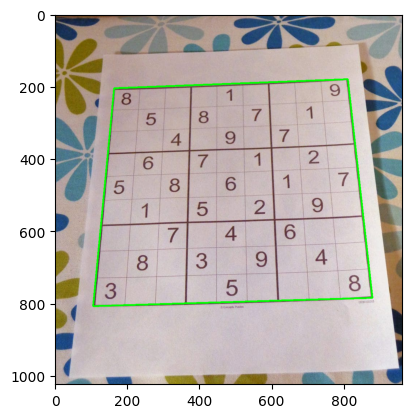

In [9]:
cv2.drawContours(img_contours, approx_rect, 0, (0, 255, 0), 3)
SHOW_IMAGE(img_contours)

## WarpTransform

На этом этапе, мы сделаем перспективу решетки на новое изображение. Размерность нового изображения мы можем задать сами, поэтому упростим себе жизнь: пусть размер каждой ячейки будет 28x28, чтобы без лишних трансформаций отправлять их в нейронную сеть. Количество ячеек в судоку - 9 на 9. Таким образом, длина и ширина изображения будут 9x28 (мы не учитываем толщину линий между ячейчками)

In [10]:
img_contours = img_rgb.copy()
output_size = 28 * 9

# Write your code here
# Составьте матрицу для warpPerspective и выполните трансформацию

largest_quad = approx_rect[0].reshape(4, 2)
    
# Упорядочение точек в порядке: верх-лев, верх-прав, низ-прав, низ-лев
# Сортировка по Y
sorted_y = largest_quad[np.argsort(largest_quad[:, 1])]
# Сортировка по X
top_points = sorted_y[:2][np.argsort(sorted_y[:2, 0])]
# Сортировка нижних точек по X (в обратном порядке)
bottom_points = sorted_y[2:][np.argsort(sorted_y[2:, 0])][::-1]
# Итоговый порядок
ordered_pts = np.float32([top_points[0], top_points[1], bottom_points[0], bottom_points[1]])

# Целевые точки для преобразования (полный квадрат output_size x output_size)
dst_pts = np.float32([
    [0, 0],
    [output_size - 1, 0],
    [output_size - 1, output_size - 1],
    [0, output_size - 1]
])

# Вычисляем матрицу перспективного преобразования
M = cv2.getPerspectiveTransform(ordered_pts, dst_pts)

warped = cv2.warpPerspective(img_contours, M, (output_size, output_size))

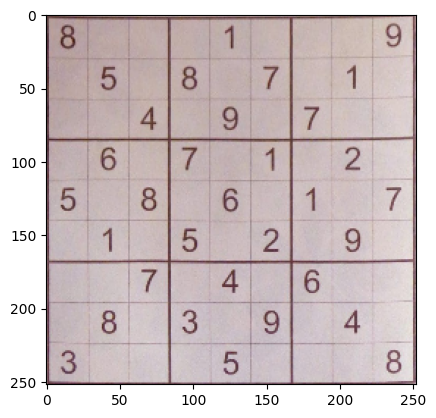

In [11]:
SHOW_IMAGE(warped)

## Разделение

Дальше ячейки будем делить не по линиям на изображении, а по предварительным расчетам, что каждая цифра находится в ячейке размером 28 на 28, а размерность решетки судоку 9 на 9

В ячейки может попасть мусор в виде границ между ячейками. От него можно избавиться с помощью великолепной функции `clear_border`, которая удаляет все ненужные части изображения по краям. 

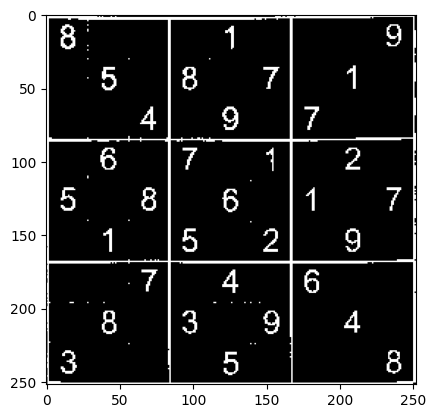

In [12]:
gray = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
_, warped_binary = cv2.threshold(gray,0,255,cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
SHOW_IMAGE(warped_binary)

In [13]:
from skimage.segmentation import clear_border
from skimage.morphology import remove_small_objects
import numpy as np

nCols = 9
nRows = 9
size = 28

grid = []
for i in range(nRows):
    grid.append([])
    for j in range(nCols):
        # Вычисляем координаты текущей клетки
        x_start = j * size
        y_start = i * size
        x_end = x_start + size
        y_end = y_start + size
        
        # Вырезаем клетку из изображения
        subImg = warped_binary[y_start:y_end, x_start:x_end].copy()
        
        # Очистка границ
        cleared = clear_border(subImg)
        
        # Удаление объектов менее 2 пикселей (остались какието артефакты)
        # bool_image = cleared.astype(bool)
        # cleaned = remove_small_objects(bool_image, min_size=2)
        
        # Конвертация
        # final_image = cleaned.astype(np.uint8) * 255
        
        grid[i].append(cleared)

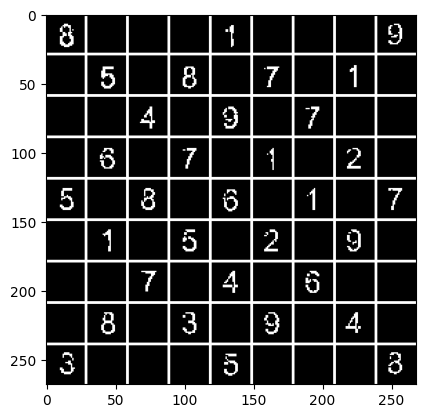

In [14]:
# Вывод всех квадратов
margin = 2  # отступ между клетками
canvas = np.ones((
    nRows * size + (nRows - 1) * margin,
    nCols * size + (nCols - 1) * margin
), dtype=np.uint8) * 255

for i in range(nRows):
    for j in range(nCols):
        y_start = i * (size + margin)
        x_start = j * (size + margin)
        canvas[y_start:y_start+size, x_start:x_start+size] = grid[i][j]

# Добавляем координаты
for i in range(nRows):
    for j in range(nCols):
        pos = (j * (size + margin) + 5, i * (size + margin) + 15)
        cv2.putText(canvas, f"{i},{j}", pos, 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)

SHOW_IMAGE(canvas)

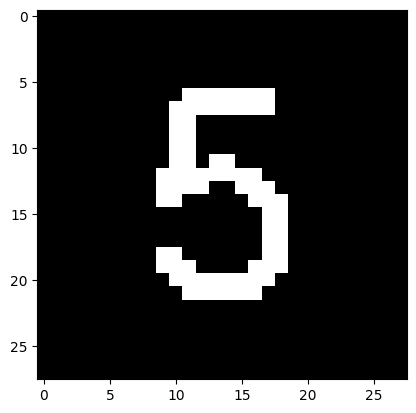

In [15]:
SHOW_IMAGE(grid[5][3])

In [16]:
# Просмотр MNIST
# import torchvision.datasets as datasets
# import torchvision.transforms as transforms

# mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# # Просмотр данных
# image, label = mnist_trainset[90]
# plt.imshow(image.squeeze(), cmap='gray')
# plt.title(f"Label: {label}")
# plt.show()

## Обучение сети для распознавания

Обучим простую сеть для распознавания цифр на MNIST. Поскольку вы уже делали похожие задания, здесь ничего дописывать не обязательно, код вернет приличную нейронку `model`, хотя вы можете попробовать по-экспериментировать с ней

In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 1024
learning_rate = 0.001
num_epochs = 15

# Enhanced data augmentation and normalization
train_transform = transforms.Compose([
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # случайные аффинные преобразования
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # перспективные искажения
    # transforms.RandomRotation(10),  # случайные повороты
    # transforms.ColorJitter(brightness=0.2, contrast=0.2), 
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3)),  # случайное стирание
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset with augmented transforms
train_dataset = torchvision.datasets.MNIST(root='./data',
                                         train=True,
                                         download=True,
                                         transform=train_transform)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                        train=False,
                                        download=True,
                                        transform=test_transform)

# Data loader with increased workers
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=8,
                         pin_memory=True)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=8,
                        pin_memory=True)

# Enhanced Neural Network with dropout
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.2),  
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2), 
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Initialize model, loss function and optimizer with weight decay
model = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), 
                      lr=learning_rate,
                      weight_decay=1e-5)  # L2 регуляризация

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                mode='max',
                                                factor=0.5,
                                                patience=1,
                                                verbose=True)

# История для графиков
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

def train(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} '
                  f'({100.*batch_idx/len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f'\nTrain Epoch: {epoch} - Loss: {epoch_loss:.4f}, Accuracy: {100.*epoch_acc:.2f}%\n')

def test():
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = correct / total
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    scheduler.step(accuracy)  # обновляем learning rate
    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{total} '
          f'({100.*accuracy:.0f}%)\n')
    return accuracy

# Train the model
best_accuracy = 0.0
for epoch in range(1, num_epochs + 1):
    train(epoch)
    current_accuracy = test()
    
    # Save best model
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

print(f"Training completed! Best accuracy: {100.*best_accuracy:.2f}%")



d:\Devtools\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306665

Train Epoch: 1 - Loss: 0.5608, Accuracy: 83.44%


Test set: Average loss: 0.1973, Accuracy: 9411/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.247998

Train Epoch: 2 - Loss: 0.2249, Accuracy: 93.23%


Test set: Average loss: 0.1327, Accuracy: 9594/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.169164

Train Epoch: 3 - Loss: 0.1569, Accuracy: 95.28%


Test set: Average loss: 0.0956, Accuracy: 9698/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.104722

Train Epoch: 4 - Loss: 0.1189, Accuracy: 96.39%


Test set: Average loss: 0.0717, Accuracy: 9778/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.095096

Train Epoch: 5 - Loss: 0.1034, Accuracy: 96.90%


Test set: Average loss: 0.0638, Accuracy: 9789/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.091908

Train Epoch: 6 - Loss: 0.0838, Accuracy: 97.39%


Test set: Average loss: 0.0624, Accuracy: 9790/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.096781

Train Epoch: 7 - L

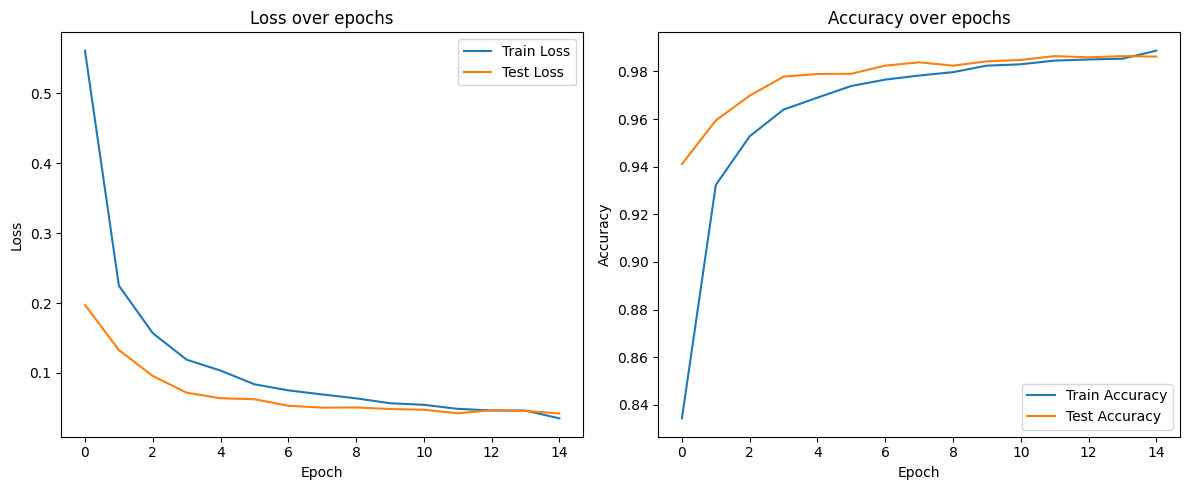

In [18]:
# Любимые графики для анализа
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
# plt.savefig('training_curves.png')
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0     0.9888    0.9939    0.9913       980
           1     0.9965    0.9912    0.9938      1135
           2     0.9827    0.9903    0.9865      1032
           3     0.9910    0.9802    0.9856      1010
           4     0.9808    0.9898    0.9853       982
           5     0.9821    0.9865    0.9843       892
           6     0.9906    0.9864    0.9885       958
           7     0.9807    0.9874    0.9840      1028
           8     0.9865    0.9774    0.9819       974
           9     0.9831    0.9802    0.9816      1009

    accuracy                         0.9864     10000
   macro avg     0.9863    0.9863    0.9863     10000
weighted avg     0.9864    0.9864    0.9864     10000



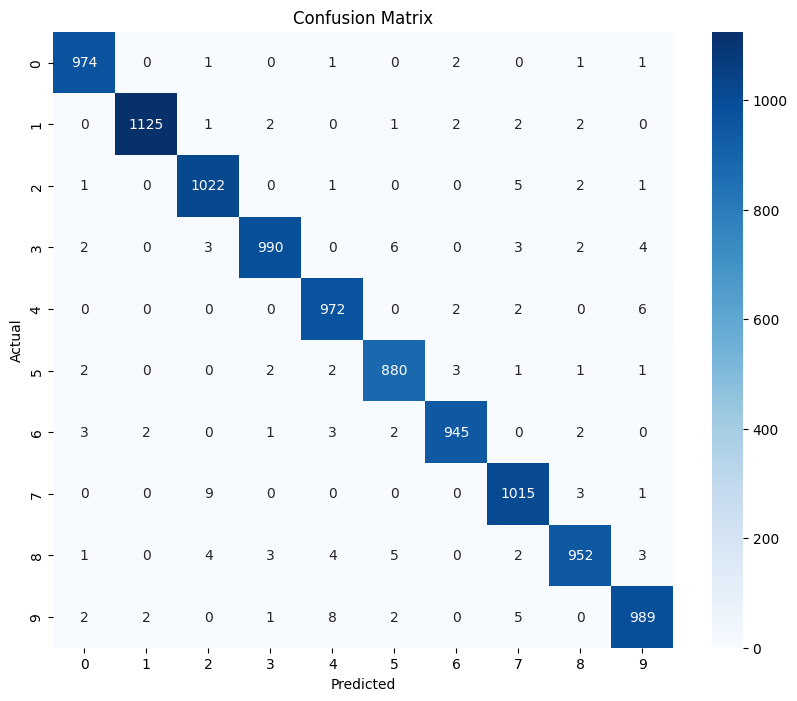

In [19]:
# Сlassification_report и confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, data_loader):
    model.eval()
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    return all_targets, all_predictions

# Загрузка лучшей модели для оценки
best_model = NeuralNetwork().to(device)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.eval()

# Предсказания для тестового набора
test_targets, test_predictions = evaluate_model(best_model, test_loader)

# Classification report
print("\nClassification Report:")
print(classification_report(test_targets, test_predictions, digits=4))

# Сonfusion matrix
conf_mat = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Итоговое распознавание

Теперь мы можем проверить, как работает нейронка на кусках изображения из нашего судоку. Поскольку у модели нет класса "пустое изображение", которые встречается в нашем случае, придется отфильтровывать такие ячейки. Мы сделаем это из предположение, что если в ячейке нет контуров, то она пустая.

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt

# Архитектура 
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.2),  
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2), 
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Инициализация устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Создание модели
model = NeuralNetwork().to(device)

# Загрузка весов лучшей модели
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()  # Перевод в режим предсказания

# Нормализация
normalize = transforms.Normalize((0.1307,), (0.3081,))

# Предсказание
for i in range(nRows):
    for j in range(nCols):
        bb = grid[i][j]
        
        # Проверка наличия контура
        contours, _ = cv2.findContours(bb, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            print(f"Ячейка ({i},{j}) пустая")
            continue
        
        # Преобразование в тензор + нормализация
        bb_tensor = torch.from_numpy(bb).unsqueeze(0).unsqueeze(0).float()
        bb_tensor = normalize(bb_tensor).to(device)
        
        # Проверка размерности
        assert bb_tensor.shape == (1, 1, 28, 28), f"Неверная размерность тензора: {bb_tensor.shape}"
        
        # Предсказание
        with torch.no_grad():
            outputs = model(bb_tensor)
            _, predicted = torch.max(outputs.data, 1)
            digit = predicted.item()
        
        print(f"Ячейка ({i},{j}): значение - {digit}")

        # Визуализация
        plt.imshow(bb, cmap='gray')
        plt.title(f"Cell ({i},{j}) - Pred: {digit}")
        plt.axis('off')
        plt.show()

Несмотря на хорошие показатели модель ошибается...

Ячейка (0,0): значение - 8, уверенность - 1.00


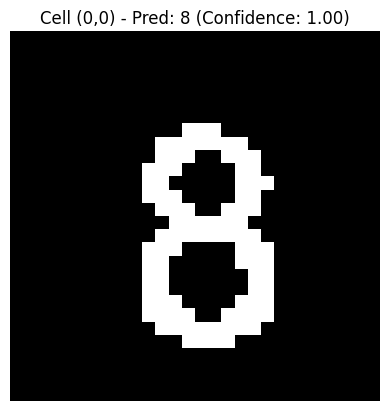

Ячейка (0,1) пустая
Ячейка (0,2) пустая
Ячейка (0,3) пустая
Ячейка (0,4): значение - 1, уверенность - 1.00


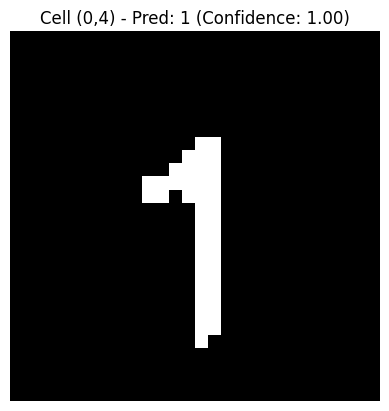

Ячейка (0,5) пустая
Ячейка (0,6) пустая
Ячейка (0,7) пустая
Ячейка (0,8): значение - 4, уверенность - 1.00


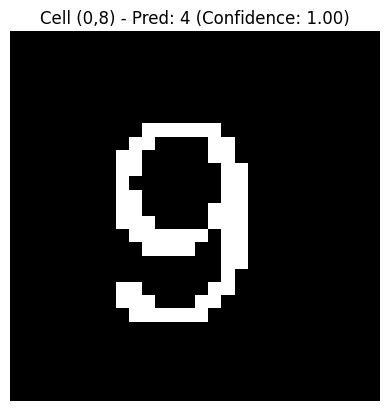

Ячейка (1,0) пустая
Ячейка (1,1): значение - 5, уверенность - 1.00


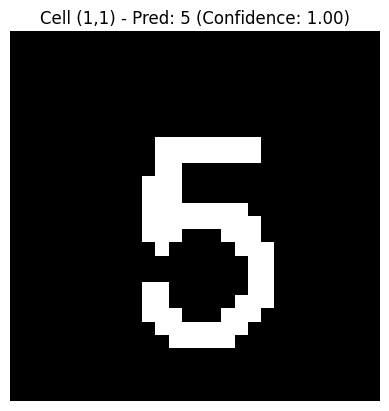

Ячейка (1,2) пустая
Ячейка (1,3): значение - 8, уверенность - 1.00


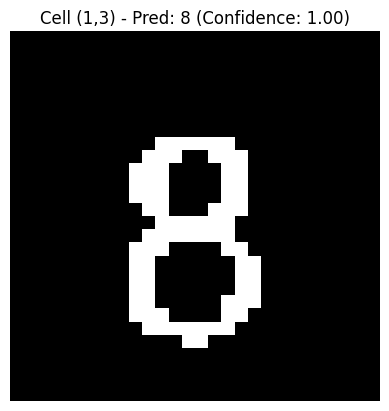

Ячейка (1,4) пустая
Ячейка (1,5): значение - 7, уверенность - 1.00


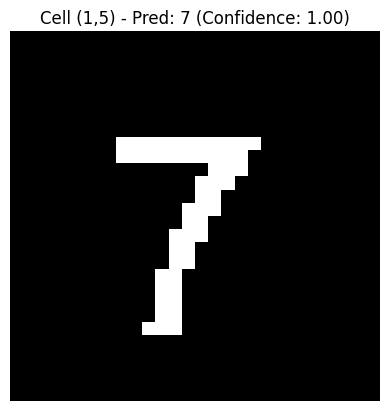

Ячейка (1,6) пустая
Ячейка (1,7): значение - 1, уверенность - 1.00


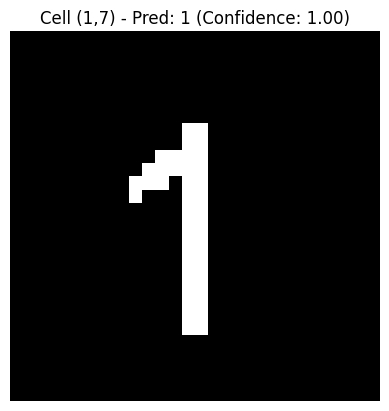

Ячейка (1,8) пустая
Ячейка (2,0) пустая
Ячейка (2,1) пустая
Ячейка (2,2): значение - 4, уверенность - 1.00


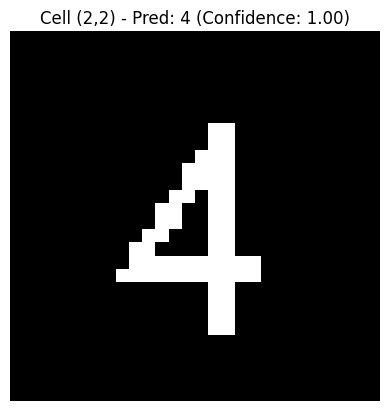

Ячейка (2,3) пустая
Ячейка (2,4): значение - 9, уверенность - 1.00


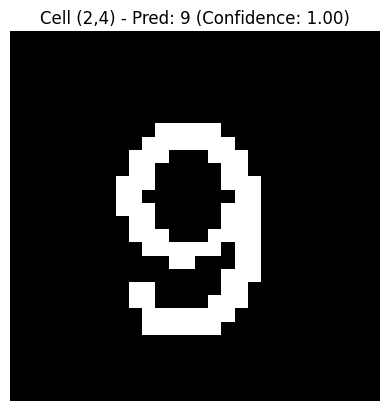

Ячейка (2,5) пустая
Ячейка (2,6): значение - 7, уверенность - 1.00


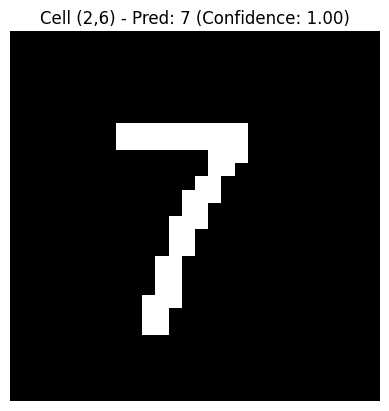

Ячейка (2,7) пустая
Ячейка (2,8) пустая
Ячейка (3,0) пустая
Ячейка (3,1): значение - 5, уверенность - 1.00


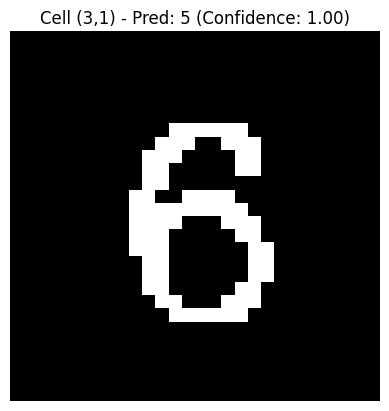

Ячейка (3,2) пустая
Ячейка (3,3): значение - 7, уверенность - 1.00


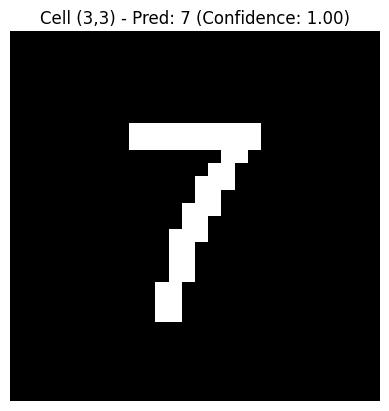

Ячейка (3,4) пустая
Ячейка (3,5): значение - 1, уверенность - 1.00


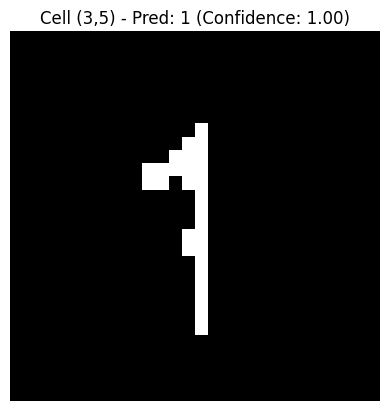

Ячейка (3,6) пустая
Ячейка (3,7): значение - 2, уверенность - 1.00


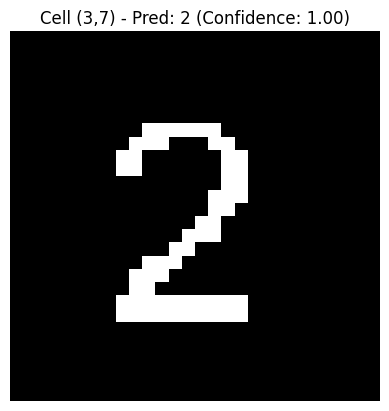

Ячейка (3,8) пустая
Ячейка (4,0): значение - 5, уверенность - 1.00


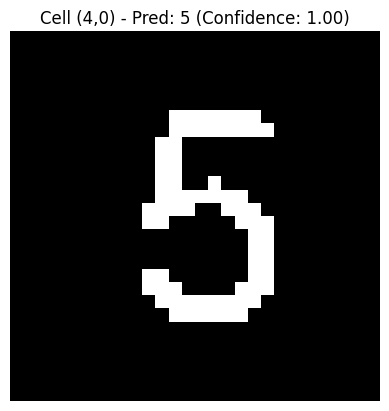

Ячейка (4,1) пустая
Ячейка (4,2): значение - 8, уверенность - 1.00


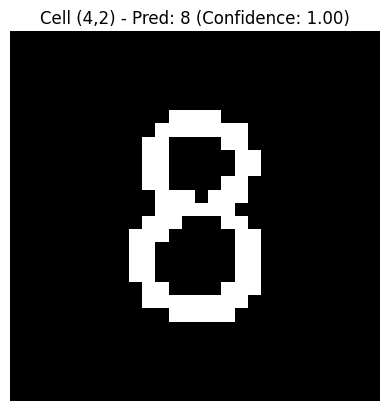

Ячейка (4,3) пустая
Ячейка (4,4): значение - 6, уверенность - 1.00


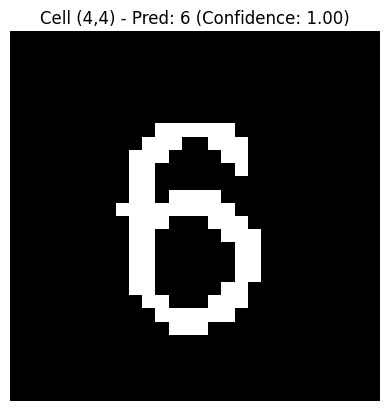

Ячейка (4,5) пустая
Ячейка (4,6): значение - 1, уверенность - 1.00


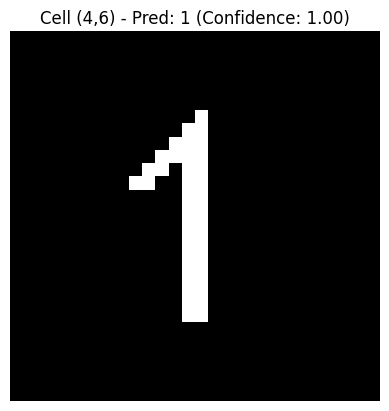

Ячейка (4,7) пустая
Ячейка (4,8): значение - 7, уверенность - 1.00


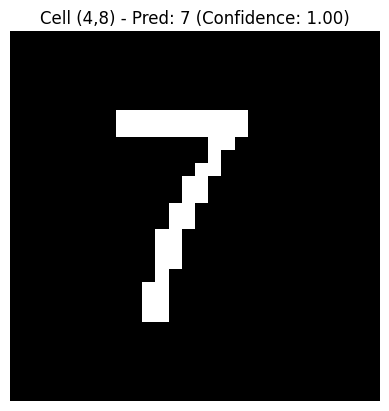

Ячейка (5,0) пустая
Ячейка (5,1): значение - 1, уверенность - 1.00


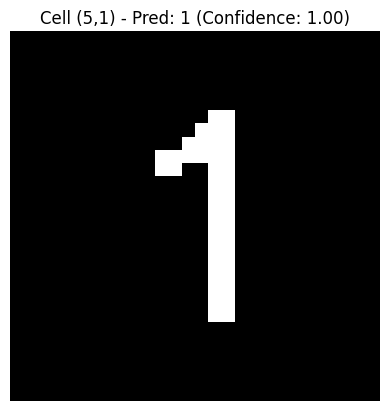

Ячейка (5,2) пустая
Ячейка (5,3): значение - 5, уверенность - 1.00


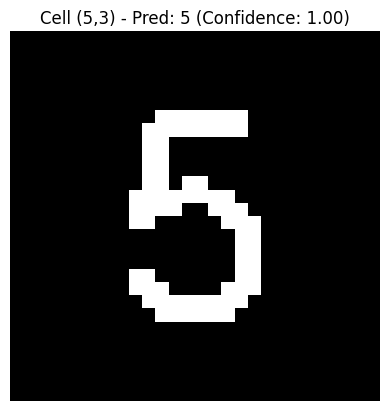

Ячейка (5,4) пустая
Ячейка (5,5): значение - 2, уверенность - 1.00


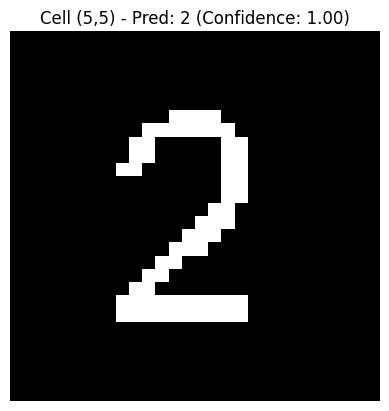

Ячейка (5,6) пустая
Ячейка (5,7): значение - 9, уверенность - 1.00


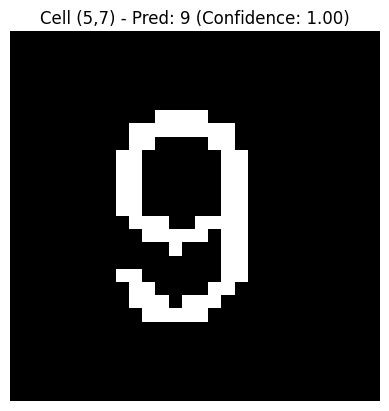

Ячейка (5,8) пустая
Ячейка (6,0) пустая
Ячейка (6,1) пустая
Ячейка (6,2): значение - 7, уверенность - 1.00


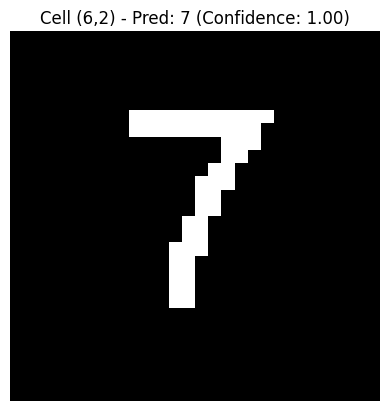

Ячейка (6,3) пустая
Ячейка (6,4): значение - 4, уверенность - 1.00


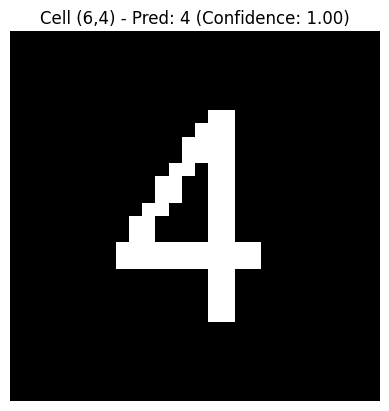

Ячейка (6,5) пустая
Ячейка (6,6): значение - 8, уверенность - 1.00


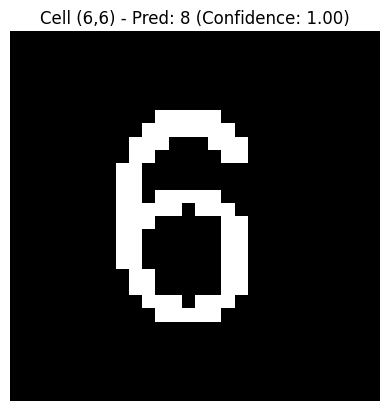

Ячейка (6,7) пустая
Ячейка (6,8) пустая
Ячейка (7,0) пустая
Ячейка (7,1): значение - 3, уверенность - 1.00


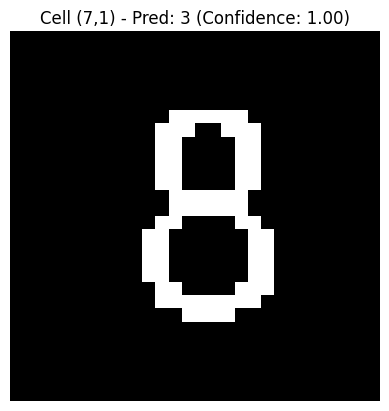

Ячейка (7,2) пустая
Ячейка (7,3): значение - 3, уверенность - 1.00


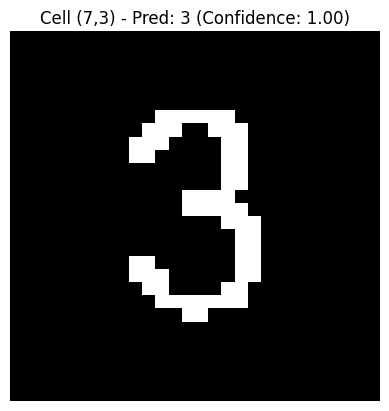

Ячейка (7,4) пустая
Ячейка (7,5): значение - 9, уверенность - 1.00


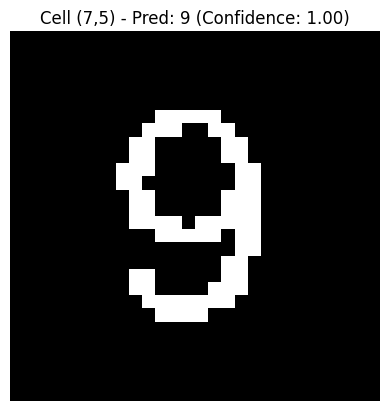

Ячейка (7,6) пустая
Ячейка (7,7): значение - 4, уверенность - 1.00


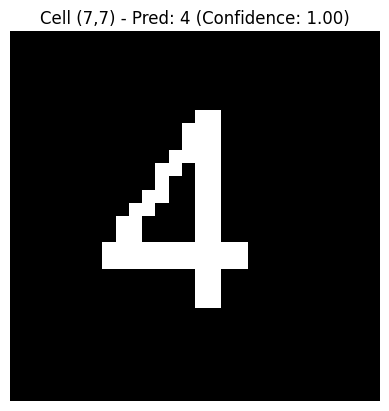

Ячейка (7,8) пустая
Ячейка (8,0): значение - 3, уверенность - 1.00


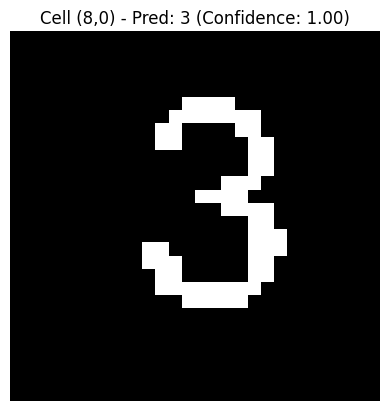

Ячейка (8,1) пустая
Ячейка (8,2) пустая
Ячейка (8,3) пустая
Ячейка (8,4): значение - 5, уверенность - 1.00


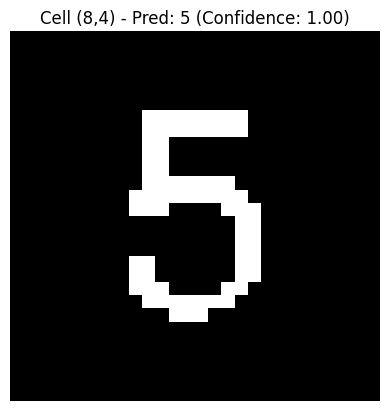

Ячейка (8,5) пустая
Ячейка (8,6) пустая
Ячейка (8,7) пустая
Ячейка (8,8): значение - 3, уверенность - 1.00


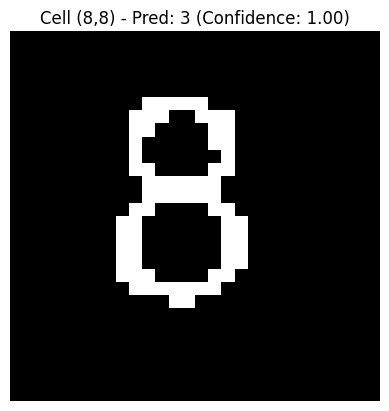

In [21]:
import torch.nn.functional as F  # Добавляем для softmax

# Предсказание
for i in range(nRows):
    for j in range(nCols):
        bb = grid[i][j]
        
        # Проверка наличия контура
        contours, _ = cv2.findContours(bb, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            print(f"Ячейка ({i},{j}) пустая")
            continue
        
        # Преобразование в тензор + нормализация
        bb_tensor = torch.from_numpy(bb).unsqueeze(0).unsqueeze(0).float()
        bb_tensor = normalize(bb_tensor).to(device)
        
        # Проверка размерности
        assert bb_tensor.shape == (1, 1, 28, 28), f"Неверная размерность тензора: {bb_tensor.shape}"
        
        # Предсказание
        with torch.no_grad():
            outputs = model(bb_tensor)
            probabilities = F.softmax(outputs, dim=1)  # Получаем вероятности
            max_prob, predicted = torch.max(probabilities, 1)
            digit = predicted.item()
            confidence = max_prob.item()  # Вероятность предсказанного класса
        
        print(f"Ячейка ({i},{j}): значение - {digit}, уверенность - {confidence:.2f}")

        # Визуализация
        plt.imshow(bb, cmap='gray')
        plt.title(f"Cell ({i},{j}) - Pred: {digit} (Confidence: {confidence:.2f})")  # Добавляем вероятность
        plt.axis('off')
        plt.show()